<a href="https://colab.research.google.com/github/georgiaceline/SystemFailureDetection/blob/main/Detecting_Anomaly_in_System_Failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['ambient_temperature_system_failure.csv']))
print(df)


Saving ambient_temperature_system_failure.csv to ambient_temperature_system_failure.csv
                timestamp      value
0     2013-07-04 00:00:00  69.880835
1     2013-07-04 01:00:00  71.220227
2     2013-07-04 02:00:00  70.877805
3     2013-07-04 03:00:00  68.959400
4     2013-07-04 04:00:00  69.283551
...                   ...        ...
7262  2014-05-28 11:00:00  72.370206
7263  2014-05-28 12:00:00  72.172956
7264  2014-05-28 13:00:00  72.046565
7265  2014-05-28 14:00:00  71.825226
7266  2014-05-28 15:00:00  72.584089

[7267 rows x 2 columns]


In [3]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('ambient_temperature_system_failure.csv')

In [7]:
df_values = df.drop('timestamp', axis=1).values

In [8]:
df_values = df_values.astype('float32')

In [9]:
df_converted = pd.DataFrame(df_values, columns=df.columns[1:])

In [10]:
df_converted.insert(0, 'timestamp', df['timestamp'])

In [12]:
df_converted = df_converted.dropna()
print(df_converted)

                timestamp      value
0     2013-07-04 00:00:00  69.880836
1     2013-07-04 01:00:00  71.220230
2     2013-07-04 02:00:00  70.877808
3     2013-07-04 03:00:00  68.959396
4     2013-07-04 04:00:00  69.283554
...                   ...        ...
7262  2014-05-28 11:00:00  72.370209
7263  2014-05-28 12:00:00  72.172958
7264  2014-05-28 13:00:00  72.046562
7265  2014-05-28 14:00:00  71.825226
7266  2014-05-28 15:00:00  72.584091

[7267 rows x 2 columns]


In [13]:
df_tensor = tf.convert_to_tensor(df_converted.drop('timestamp', axis=1).values, dtype=tf.float32)

input_dim = df_converted.shape[1] - 1
encoding_dim = 10


input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(df_tensor, df_tensor, epochs=50,
                batch_size=32, shuffle=True)


reconstructions = autoencoder.predict(df_tensor)
mse = tf.reduce_mean(tf.square(df_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = df_converted.index


Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1828.8090
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.9607
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0013
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0013
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 12/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 13/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 14/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 15/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

In [15]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

In [16]:
test = df_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


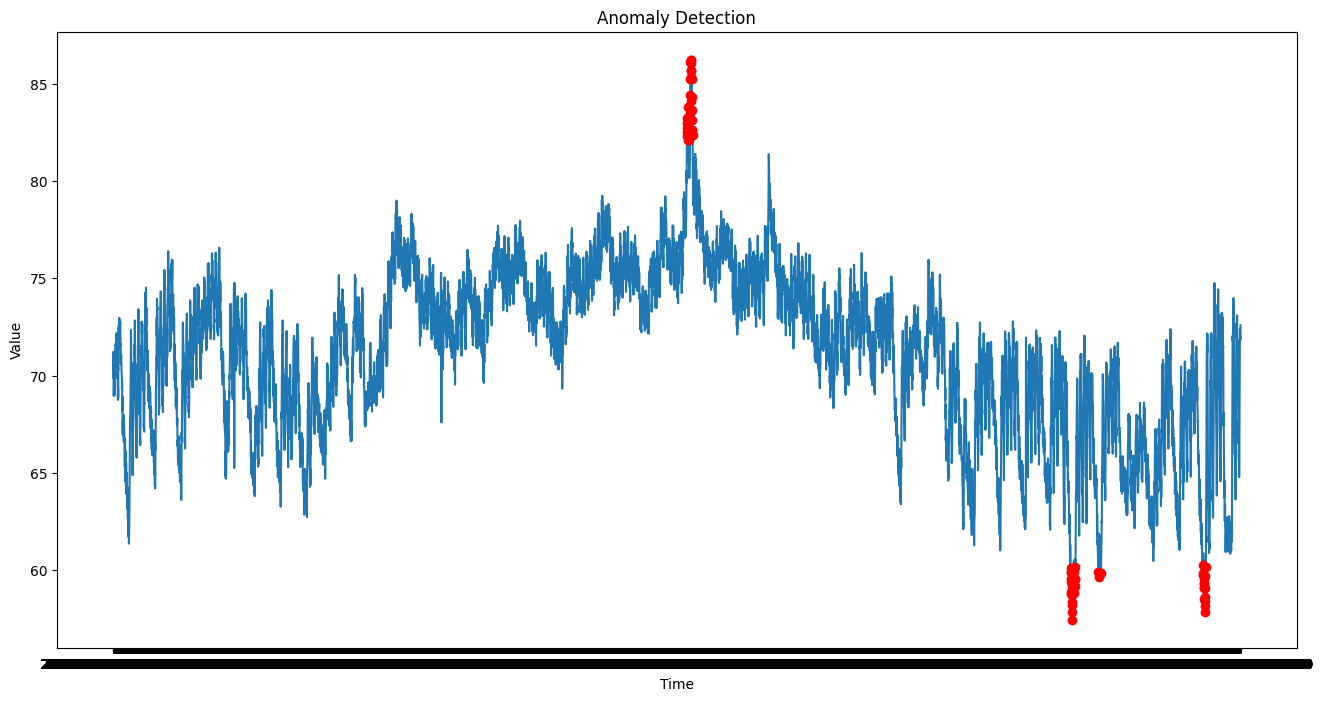

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(df_converted['timestamp'],
         df_converted['value'])
plt.plot(df_converted['timestamp'][anomalous],
         df_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()